In [66]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler,OrdinalEncoder
from sklearn.impute import SimpleImputer
#from category_encoders import OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

from sklearn.pipeline import Pipeline,make_pipeline

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, roc_auc_score

RANDOM_SEED = 6    # Set a random seed for reproducibility!

In [2]:
DATA_PATH = Path.cwd().parent / "Downloads"

In [54]:
features_df = pd.read_csv(
    DATA_PATH / "training_set_features.csv", 
    index_col="respondent_id"
)
labels_df = pd.read_csv(
    DATA_PATH / "training_set_labels.csv", 
    index_col="respondent_id"
)

In [4]:
print("features_df.shape", features_df.shape)
features_df.head()

features_df.shape (26707, 35)


,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [5]:
features_df.dtypes

h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                             object
income_poverty           

In [6]:
print("labels_df.shape", labels_df.shape)
labels_df.head()

labels_df.shape (26707, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
0,0,0
1,0,1
2,0,0
3,0,1
4,0,0


Check that the rows of features and labels match(same index). Numpy's assert_array_equal will error if the two arrays—the row indices of the two data frames—don't match up.

In [7]:
np.testing.assert_array_equal(features_df.index.values, labels_df.index.values)

# Data Exploration

In [8]:
labels_df['h1n1_vaccine'].value_counts(normalize=True)

0    0.787546
1    0.212454
Name: h1n1_vaccine, dtype: float64

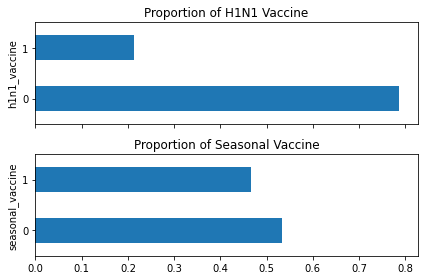

In [9]:
fig, ax = plt.subplots(2, 1, sharex=True)

(labels_df['h1n1_vaccine']
    .value_counts(normalize=True)
    .plot.barh(title="Proportion of H1N1 Vaccine", ax=ax[0])
)
ax[0].set_ylabel("h1n1_vaccine")

(labels_df['seasonal_vaccine']
    .value_counts(normalize=True)
    .plot.barh(title="Proportion of Seasonal Vaccine", ax=ax[1])
)
ax[1].set_ylabel("seasonal_vaccine")

fig.tight_layout()


Seasonal flu vaccine target has balanced classes, but the H1N1 flu vaccine target has moderately imbalanced classes.

Check whether target variables are independent using crosstab and correlation coefficient.

In [10]:
pd.crosstab(
    labels_df["h1n1_vaccine"], 
    labels_df["seasonal_vaccine"], 
    margins=True,
    normalize=True
)

seasonal_vaccine,0,1,All
h1n1_vaccine,,,
0,0.497810,0.289737,0.787546
1,0.036582,0.175871,0.212454
All,0.534392,0.465608,1.000000


In [11]:
labels_df["seasonal_vaccine"].corr(labels_df["h1n1_vaccine"])

0.377142653061445

Moderate positive correlation.

# Features

In [12]:
joined_df = features_df.join(labels_df)
print(joined_df.shape)
joined_df.head()

(26707, 37)


,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [13]:
joined_df["h1n1_concern"].value_counts()

2.0    10575
1.0     8153
3.0     4591
0.0     3296
Name: h1n1_concern, dtype: int64

In [14]:
counts = (joined_df[['h1n1_concern', 'h1n1_vaccine']]
              .groupby(['h1n1_concern', 'h1n1_vaccine'])
              .size()
              .unstack('h1n1_vaccine')
         )
counts

h1n1_vaccine,0,1
h1n1_concern,,
0.0,2849,447
1.0,6756,1397
2.0,8102,2473
3.0,3250,1341


In [15]:
h1n1_concern_counts = counts.sum(axis='columns') #same as value_counts()
h1n1_concern_counts

h1n1_concern
0.0     3296
1.0     8153
2.0    10575
3.0     4591
dtype: int64

In [16]:
#Finding out what proportion of h1n1_concern got h1n1_vaccine
props = counts.div(h1n1_concern_counts, axis='index')
props

h1n1_vaccine,0,1
h1n1_concern,,
0.0,0.864381,0.135619
1.0,0.828652,0.171348
2.0,0.766147,0.233853
3.0,0.707907,0.292093


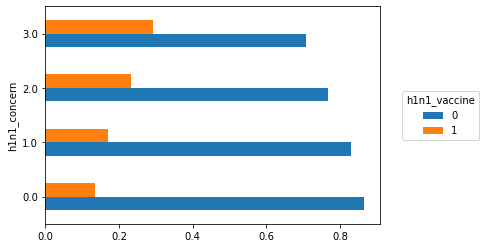

In [17]:
props.plot.barh()
plt.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5),
    title='h1n1_vaccine'
);

So ther's a clear relationship between h1n1_concern and h1n1_vaccine. The more concerned the people are the more likely they are to get vaccine.

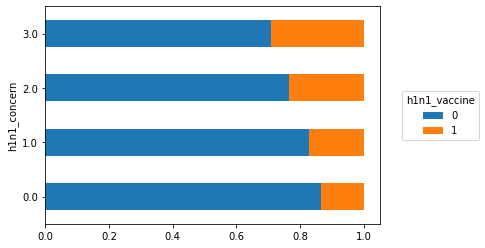

In [18]:
props.plot.barh(stacked=True)
plt.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5),
    title='h1n1_vaccine'
);

In [19]:
def vaccination_rate_plot(col, target, data, ax=None):
    """Stacked bar chart of vaccination rate for `target` against 
    `col`. 
    
    Args:
        col (string): column name of feature variable
        target (string): column name of target variable
        data (pandas DataFrame): dataframe that contains columns 
            `col` and `target`
        ax (matplotlib axes object, optional): matplotlib axes 
            object to attach plot to
    """
    counts = (joined_df[[target, col]]
                  .groupby([target, col])
                  .size()
                  .unstack(target)
             )
    group_counts = counts.sum(axis='columns')
    props = counts.div(group_counts, axis='index')

    props.plot(kind="barh", stacked=True, ax=ax)
    ax.invert_yaxis()
    ax.legend().remove()

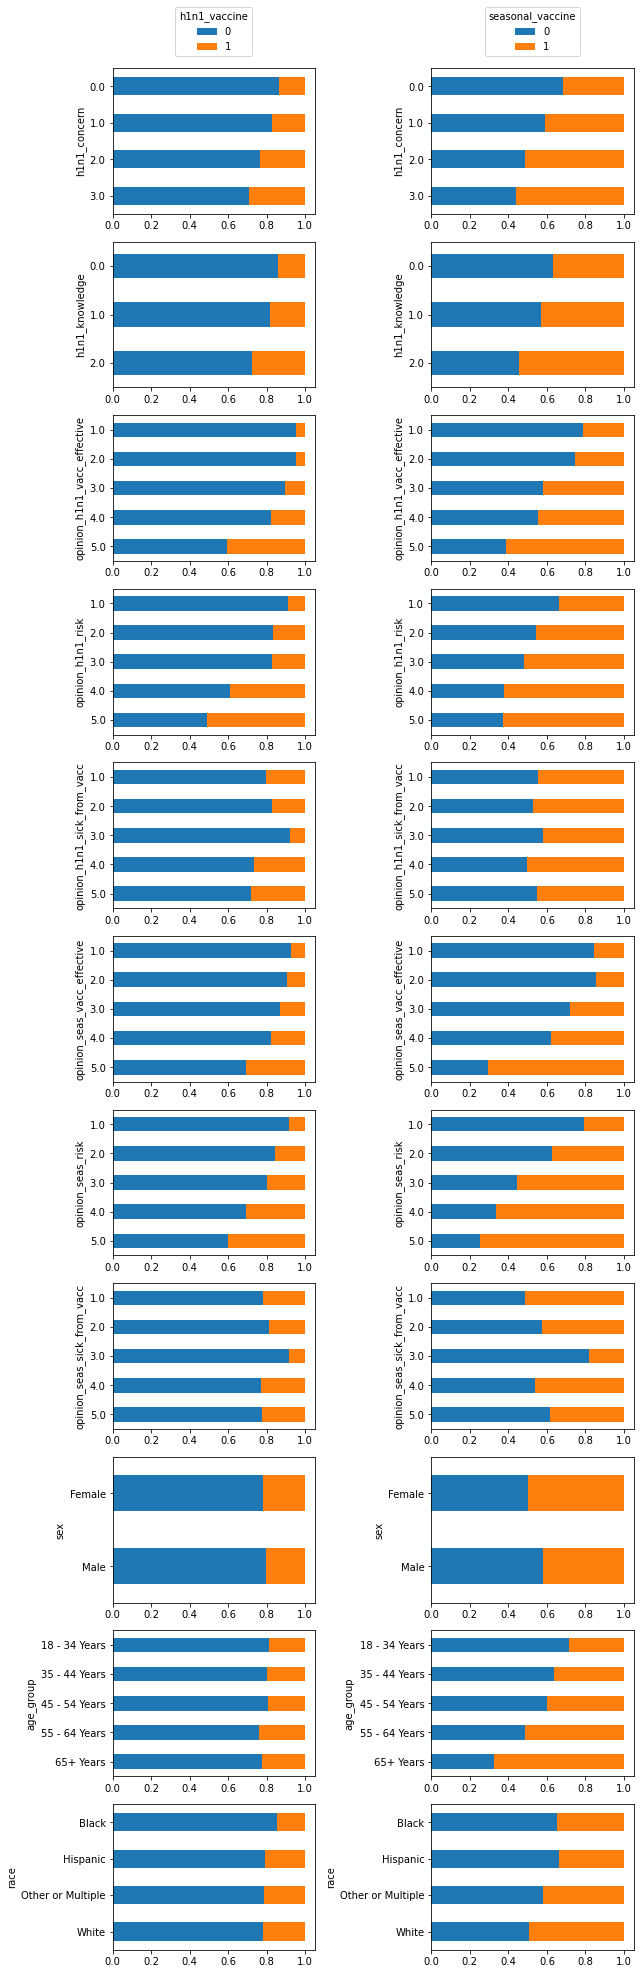

In [20]:
cols_to_plot = [
    'h1n1_concern',
    'h1n1_knowledge',
    'opinion_h1n1_vacc_effective',
    'opinion_h1n1_risk',
    'opinion_h1n1_sick_from_vacc',
    'opinion_seas_vacc_effective',
    'opinion_seas_risk',
    'opinion_seas_sick_from_vacc',
    'sex',
    'age_group',
    'race',
]

fig, ax = plt.subplots(
    len(cols_to_plot), 2, figsize=(9,len(cols_to_plot)*2.5)
)
for idx, col in enumerate(cols_to_plot):
    vaccination_rate_plot(
        col, 'h1n1_vaccine', joined_df, ax=ax[idx, 0]
    )
    vaccination_rate_plot(
        col, 'seasonal_vaccine', joined_df, ax=ax[idx, 1]
    )
    
ax[0, 0].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine'
)
ax[0, 1].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine'
)
fig.tight_layout()

In [52]:
#Find % missing values
for col in features_df:
    missing_values = round(((features_df[col].isna().sum())/len(features_df))*100,2)
    print(col ,":",missing_values )

h1n1_concern : 0.34
h1n1_knowledge : 0.43
behavioral_antiviral_meds : 0.27
behavioral_avoidance : 0.78
behavioral_face_mask : 0.07
behavioral_wash_hands : 0.16
behavioral_large_gatherings : 0.33
behavioral_outside_home : 0.31
behavioral_touch_face : 0.48
doctor_recc_h1n1 : 8.09
doctor_recc_seasonal : 8.09
chronic_med_condition : 3.64
child_under_6_months : 3.07
health_worker : 3.01
health_insurance : 45.96
opinion_h1n1_vacc_effective : 1.46
opinion_h1n1_risk : 1.45
opinion_h1n1_sick_from_vacc : 1.48
opinion_seas_vacc_effective : 1.73
opinion_seas_risk : 1.92
opinion_seas_sick_from_vacc : 2.01
age_group : 0.0
education : 5.27
race : 0.0
sex : 0.0
income_poverty : 16.56
marital_status : 5.27
rent_or_own : 7.65
employment_status : 5.48
hhs_geo_region : 0.0
census_msa : 0.0
household_adults : 0.93
household_children : 0.93
employment_industry : 49.91
employment_occupation : 50.44


In [55]:
#Drop columns having 50% null values
features_df.drop(columns=["health_insurance","employment_industry","employment_occupation"],inplace=True)
features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

In [56]:
numeric_cols = features_df.columns[features_df.dtypes != "object"].values
print(numeric_cols)

['h1n1_concern' 'h1n1_knowledge' 'behavioral_antiviral_meds'
 'behavioral_avoidance' 'behavioral_face_mask' 'behavioral_wash_hands'
 'behavioral_large_gatherings' 'behavioral_outside_home'
 'behavioral_touch_face' 'doctor_recc_h1n1' 'doctor_recc_seasonal'
 'chronic_med_condition' 'child_under_6_months' 'health_worker'
 'opinion_h1n1_vacc_effective' 'opinion_h1n1_risk'
 'opinion_h1n1_sick_from_vacc' 'opinion_seas_vacc_effective'
 'opinion_seas_risk' 'opinion_seas_sick_from_vacc' 'household_adults'
 'household_children']


In [43]:
#Another way of getting numeric columns as list
# numeric_cols = list(features_df.select_dtypes("number").columns.values)
# numeric_cols

list

In [57]:
categorical_col = features_df.columns[features_df.dtypes == "object"].values
print(categorical_col)

['age_group' 'education' 'race' 'sex' 'income_poverty' 'marital_status'
 'rent_or_own' 'employment_status' 'hhs_geo_region' 'census_msa']


In [59]:
# chain preprocessing into a Pipeline object
# each step is a tuple of (name you chose, sklearn transformer)
numeric_preprocessing_steps = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('simple_imputer', SimpleImputer(strategy='median'))
])
categorical_preprocessing_steps = Pipeline(
    [
        ('ordinal_encoder',OrdinalEncoder()),
        ('impute_categorical',SimpleImputer(strategy='median'))
    
])
# create the preprocessor stage of final pipeline
# each entry in the transformer list is a tuple of
# (name you choose, sklearn transformer, list of columns)
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_steps, numeric_cols),
        ("categorical", categorical_preprocessing_steps, categorical_col)
    ],
    remainder = "drop"
)

In [60]:
#Create estimator
estimators = MultiOutputClassifier(
    estimator=LogisticRegression(penalty="l2", C=1)
)

In [61]:
full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", estimators),
])

In [62]:
full_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler()),
                                                                  ('simple_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  array(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask',
       'behavioral_wash_hands', 'behavioral_large_gatherings',
       '...
                                                 ('categorical',
                                                  Pipeline(steps=[('ordinal_encoder',
                                                                   OrdinalEncoder()),
                                                          

# Training and Evaluation

In [63]:
#Split the features_df and labels_df into training and test sets
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    labels_df,
    test_size=0.33,
    shuffle=True,
    stratify=labels_df,
    random_state=RANDOM_SEED
)
print("X_train shape:", X_train.shape)
print("X_eval shape:", X_eval.shape)
print("y_train shape:", y_train.shape)
print("y_eval shape:", y_eval.shape)

X_train shape: (17893, 32)
X_eval shape: (8814, 32)
y_train shape: (17893, 2)
y_eval shape: (8814, 2)


In [64]:
%%time

# Train model
full_pipeline.fit(X_train, y_train)

# Predict on evaluation set
# This competition wants probabilities, not labels
preds = full_pipeline.predict_proba(X_eval)
preds

CPU times: total: 750 ms
Wall time: 285 ms


[array([[0.70620082, 0.29379918],
        [0.89707293, 0.10292707],
        [0.78399944, 0.21600056],
        ...,
        [0.92804799, 0.07195201],
        [0.9282076 , 0.0717924 ],
        [0.93773619, 0.06226381]]),
 array([[0.64429203, 0.35570797],
        [0.58072793, 0.41927207],
        [0.26948759, 0.73051241],
        ...,
        [0.85946208, 0.14053792],
        [0.90790114, 0.09209886],
        [0.15309799, 0.84690201]])]

In [75]:
print("pred_probas[0].shape", preds[0].shape)
print("pred_probas[1].shape", preds[1].shape)

pred_probas[0].shape (8814, 2)
pred_probas[1].shape (8814, 2)


Taking probabilities of class 1 for both targets(2nd column) and putting them into a dataframe.

In [69]:
y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": preds[0][:, 1],
        "seasonal_vaccine": preds[1][:, 1],
    },
    index = y_eval.index
)
print("y_preds.shape:", y_preds.shape)
y_preds.head()

y_preds.shape: (8814, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
6728,0.293799,0.355708
16516,0.102927,0.419272
3106,0.216001,0.730512
16981,0.709727,0.895640
19111,0.300966,0.777672


In [70]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

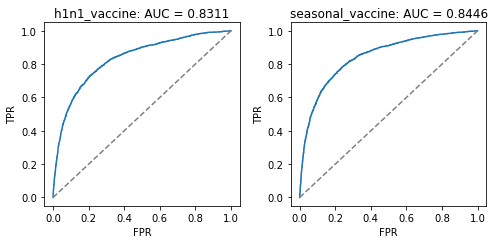

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

plot_roc(
    y_eval['h1n1_vaccine'], 
    y_preds['h1n1_vaccine'], 
    'h1n1_vaccine',
    ax=ax[0]
)
plot_roc(
    y_eval['seasonal_vaccine'], 
    y_preds['seasonal_vaccine'], 
    'seasonal_vaccine',
    ax=ax[1]
)
fig.tight_layout()

The competition metric is the average between these two AUC values. Scikit-learn's roc_auc_score does support multilabel, so we can use that directly.

In [72]:
roc_auc_score(y_eval, y_preds)

0.83783282952867

# Retrain model on full dataset

In [73]:
%%time 

full_pipeline.fit(features_df, labels_df)

CPU times: total: 1.08 s
Wall time: 393 ms


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler()),
                                                                  ('simple_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  array(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask',
       'behavioral_wash_hands', 'behavioral_large_gatherings',
       '...
                                                 ('categorical',
                                                  Pipeline(steps=[('ordinal_encoder',
                                                                   OrdinalEncoder()),
                                                          

In [74]:
#Read 'test_set_features' into a dataframe
test_features_df = pd.read_csv(DATA_PATH / "test_set_features.csv", 
                               index_col="respondent_id")

In [76]:
test_probas = full_pipeline.predict_proba(test_features_df)
test_probas

[array([[0.9280445 , 0.0719555 ],
        [0.95227414, 0.04772586],
        [0.5534132 , 0.4465868 ],
        ...,
        [0.86618583, 0.13381417],
        [0.94371086, 0.05628914],
        [0.44675768, 0.55324232]]),
 array([[0.79970696, 0.20029304],
        [0.94803348, 0.05196652],
        [0.30901948, 0.69098052],
        ...,
        [0.8005211 , 0.1994789 ],
        [0.55606835, 0.44393165],
        [0.45453039, 0.54546961]])]

In [77]:
#Read "submission_format.csv" into a dataframe
submission_df = pd.read_csv(DATA_PATH / "submission_format.csv", 
                            index_col="respondent_id")

In [78]:
submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.5,0.7
26708,0.5,0.7
26709,0.5,0.7
26710,0.5,0.7
26711,0.5,0.7


In [79]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test_features_df.index.values, 
                              submission_df.index.values)

# Save predictions to submission data frame
submission_df["h1n1_vaccine"] = test_probas[0][:, 1]
submission_df["seasonal_vaccine"] = test_probas[1][:, 1]

submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.071956,0.200293
26708,0.047726,0.051967
26709,0.446587,0.690981
26710,0.485066,0.879711
26711,0.219243,0.476684


In [80]:
submission_df.to_csv('my_submission.csv', index=True)